# Combine DIC data with X-ray in order to calculate multiaxial flow curve

- Use pylab inline

In [3]:
pwd

u'/Users/yj/repo/FLD_DIC_XRAY/tutorials/XRD_analysis/IF_steel/PSRD'

In [4]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


- Dependents

In [5]:
import os, time
from MP.mat import mech
from glob import glob
import RS
reload(RS)
from RS import sfig_class
reload(sfig_class)

from RS import analyze_proto,sff_plot
import matplotlib as mpl
from MP import progress_bar, lib
from MP import mat
mech=mat.mech

mpl_lib=lib.mpl_lib
uet=progress_bar.update_elapsed_time
GS=mpl.gridspec.GridSpec
fc=mat.mech.FlowCurve

- Name of DIC files

In [6]:
ls -ls /Users/yj/Documents/ExpDat/IFSteel/Marciniak-X-ray-IF/PS/20141112/DIC

total 437904
    8 -rw-r--r--@ 1 yj  admin       409 May 15 22:19 Bsteel_fref_DIC.sff
    8 -rw-r--r--  1 yj  admin      3726 Sep  9 12:34 DIC_results.txt
19904 -rw-------  1 yj  admin  10190529 May 18 11:56 IFsteel_PSRD-0000_0.mat
19904 -rw-------  1 yj  admin  10190529 May 18 11:56 IFsteel_PSRD-0001_0.mat
19904 -rw-------  1 yj  admin  10190529 May 18 11:56 IFsteel_PSRD-0002_0.mat
19904 -rw-------  1 yj  admin  10190529 May 18 11:56 IFsteel_PSRD-0003_0.mat
19904 -rw-------  1 yj  admin  10190529 May 18 11:57 IFsteel_PSRD-0004_0.mat
19904 -rw-------  1 yj  admin  10190529 May 18 11:57 IFsteel_PSRD-0005_0.mat
19904 -rw-------  1 yj  admin  10190529 May 18 11:57 IFsteel_PSRD-0006_0.mat
19904 -rw-------  1 yj  admin  10190529 May 18 11:57 IFsteel_PSRD-0007_0.mat
19904 -rw-------  1 yj  admin  10190529 May 18 11:57 IFsteel_PSRD-0008_0.mat
19904 -rw-------  1 yj  admin  10190529 May 18 11:57 IFsteel_PSRD-0009_0.mat
19904 -rw-------  1 yj  admin  10190529 May 18 11:57 IFsteel_PSRD-0010_0.ma

In [7]:
date='20141112'
path='/Users/yj/Documents/ExpDat/IFSteel/Marciniak-X-ray-IF/PS/'
fn_DIC=os.path.join(path,date,'DIC/DIC_results.txt')
dic_dat=np.loadtxt(fn_DIC,skiprows=1).T

# Read lab note book in order to match Xray file and DIC index

In [10]:
print os.popen('ls %s'%os.path.join(path,'Xray/*.tr')).read()

- Making a fref file for Proto data analysis

In [12]:
major_vij=2
# ------------------------------------------------------------------------
# Find suitable experimental stress factor file
#fn_sff='/Users/yj/GoogleDrive/expdat/Marciniak-X-ray-IF/YJ_BB_10times.sff'
fn_sff='/Users/yj/Documents/ExpDat/IFSteel/Marciniak-X-ray-IF/IF_PSRD.sff'

# ------------------------------------------------------------------------
# Refer to Laboratory notebook to match up the X-ray data filename 
# and DIC image number
DIC_XRD="""#8  12NOV14_0005.tr
#9    12NOV14_0006.tr
#11  12NOV14_0007.tr
#12  12NOV14_0008.tr
#13  12NOV14_0009.tr
#14  12NOV14_0010.tr
#15  12NOV14_0011.tr
#16  12NOV14_0012.tr
#17  12NOV14_0013.tr
#18  12NOV14_0014.tr
#19  12NOV14_0015.tr
#20  12NOV14_0016.tr"""

# ------------------------------------------------------------------------

In [16]:
fn_fref=fn_DIC.split('DIC')[0]+'f_fref.txt'
f_fref=open(fn_fref,'w')


f_fref.write(fn_sff)
f_fref.write('  MajorStrainColumn: %i\n'%major_vij)
f_fref.write(('%14s'+'%12s '*4+' %5s'+'%12s '*4+' %14s\n')%(
        'filename','Exx','Eyy','Exy','Ezz','DIC','Exx_e','Eyye','SIG_a','SIG_e','Date'))
lines=DIC_XRD.split('\n')
inds = []; fns = []
## flow curve obj
myfc=fc()
Ex,Ey,Exy,Ez=[],[],[],[]

Ex_std =[]
Ey_std =[]
DIC_sigma_avg=[]; DIC_sigma_std=[]
for line in lines:
    ind,fn=line.split()
    ind=int(ind.split('#')[-1])
    fn = fn.split('.tr')[0]
    inds.append(ind); fns.append(fn)
    
    col = dic_dat[0]
    ix=np.where(col==ind)[0]
    i = int(col[ix][0]) ## dic index
    # print ix,i

    exx = dic_dat[5][ix]
    eyy = dic_dat[7][ix]
    exy = dic_dat[9][ix]
    ezz = -exx-eyy    
    
    # -----------------------------------------
    """ Additional elements..."""
    exx_std       = dic_dat[6][ix]
    eyy_std       = dic_dat[8][ix]
    DIC_sigma_a   = dic_dat[11][ix]
    DIC_sigma_e   = dic_dat[12][ix]
    # -----------------------------------------

    f_fref.write(('%14s '+'%+11.5e '*4+'%5i '+'%+11.5e '*4+' %14s\n')%(
            fn, exx, eyy, exy, ezz,i,exx_std,eyy_std,DIC_sigma_e,DIC_sigma_e,date))
    Ex.append(exx);Ey.append(eyy);Exy.append(exy);Ez.append(ezz)
    Ex_std.append(exx_std)
    Ey_std.append(eyy_std)
    DIC_sigma_avg.append(DIC_sigma_a)
    DIC_sigma_std.append(DIC_sigma_e)
    

myfc.get_strain(Ex,0,0)
myfc.get_strain(Ey,1,1)
myfc.get_strain(Exy,0,1)
myfc.get_strain(Exy,1,0)
myfc.get_strain(Ez,2,2)
myfc.set_zero_epsilon_ij(2,1)
myfc.set_zero_epsilon_ij(0,2)
myfc.get_vm_strain()
myfc.get_vm_stress()

myfc.DIC_sigma_avg=DIC_sigma_avg
myfc.DIC_sigma_std=DIC_sigma_std
myfc.Ex_std=Ex_std
myfc.Ey_std=Ey_std

f_fref.close()
print '-'*50
print fn_fref, 'has been created:\n Use it for further stress analysis'
print '-'*50

--------------------------------------------------
/Users/yj/Documents/ExpDat/IFSteel/Marciniak-X-ray-IF/PS/20141112/f_fref.txt has been created:
 Use it for further stress analysis
--------------------------------------------------


In [17]:
print os.popen('head -n 5 %s'%fn_fref).read()

/Users/yj/Documents/ExpDat/IFSteel/Marciniak-X-ray-IF/IF_PSRD.sff  MajorStrainColumn: 2
      filename         Exx          Eyy          Exy          Ezz    DIC       Exx_e         Eyye        SIG_a        SIG_e            Date
  12NOV14_0005 +4.36463e-02 +1.95225e-03 -1.30273e-04 -4.55986e-02     8 +7.54810e-03 +4.05568e-03 +8.73740e-03 +8.73740e-03        20141112
  12NOV14_0006 +7.86776e-02 +1.89357e-03 -6.44852e-04 -8.05712e-02     9 +9.65188e-03 +5.67547e-03 +9.50824e-03 +9.50824e-03        20141112
  12NOV14_0007 +1.11479e-01 +1.51133e-03 -1.14030e-03 -1.12990e-01    11 +1.15860e-02 +6.31501e-03 +8.18694e-03 +8.18694e-03        20141112



# Running analyze_proto.main for the X-ray and DIC experiments

+ Determine representative strain levels for stress determination

In [20]:
#sff_plot.'/Users/yj/Documents/ExpDat/IFSteel/Marciniak-X-ray-IF/IF_PSRD.sff'
eps_sff=sff_plot.readeps(fn=fn_sff,lb='\n')
print eps_sff
fc_sff=fc()


# for PSRD, E1=eps_sff
e11=np.array(eps_sff)
e22=np.zeros((len(e11),))
e33=-e11
print e11,e22,e33

fc_sff.get_strain(e11,i=0,j=0)
fc_sff.get_strain(e22,i=1,j=1)
fc_sff.get_strain(e33,i=2,j=2)
fc_sff.set_zero_shear_strain()
fc_sff.get_vm_strain()
print 'von mises strain:'
print fc_sff.epsilon_vm

[0.0, 0.165, 0.3]
[ 0.     0.165  0.3  ] [ 0.  0.  0.] [-0.    -0.165 -0.3  ]
von mises strain:
[ 0.          0.19052559  0.34641016]


+ Running analyze_proto.main for the X-ray and DIC experiments to calculate
  stress/strain

In [21]:
## plastic strain of the points where the X-ray d-spacing
## were meausured are important information that is utilized over the X ray analysis.
## If, fc or fn_str are not given, the below application
## bases on the strain given in the fref file -
## the two major strain components are used with assumption
## that the sample was in 'equi-biaxial' strain.

t0=time.time()
RS=analyze_proto.main(
    path=os.path.join(path,date,'Xray'),
    fn_sf=fn_sff,fref=fn_fref,fc=fc_sff,
    ind_plot=True)
uet(time.time()-t0);print

fc was given

#-----------------------------------------------------#
 Interpolate SF and IG for matching with D-spacings
epsilon_vm:
[ 0.05156251  0.09196182  0.12960624  0.16462464  0.19937767  0.23206009
  0.26419181  0.29559951  0.3268179   0.35555388  0.39018311  0.43928791]
Strain reference at which sf was measured:
[ 0.          0.19052559  0.34641016]
  ** Phi angles of SF are different **
  ** Phi angles of IG are different **
#-----------------------------------------------------#
-----------------------------------
Standard deviation in d_ehkl at istp=0

phi:    -135      -45        0       90  avg
std: 1.5e-04  1.3e-04  1.5e-04  1.1e-04  1.3e-04 
Elapsed time:  19 [sec]


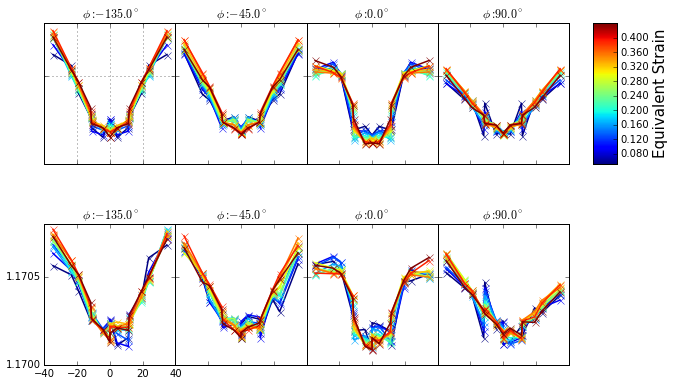

In [22]:
# print RS.EXP.ehkl.shape
#print RS.EXP.nphi, RS.EXP.npsi
RS.EXP.plot_all()

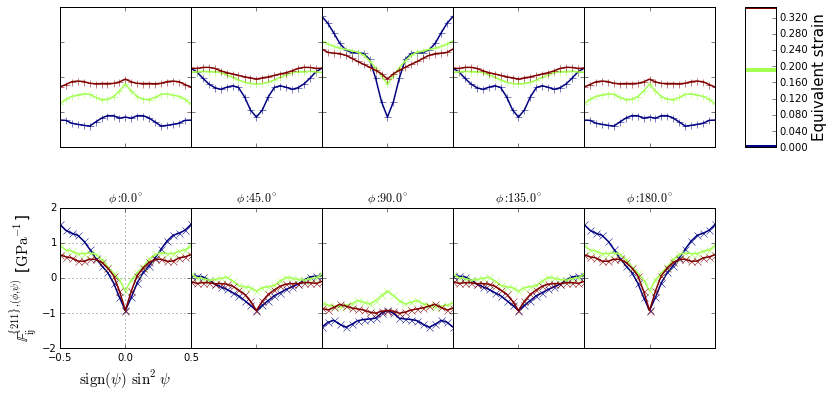

In [23]:
RS.SF_orig.plot()

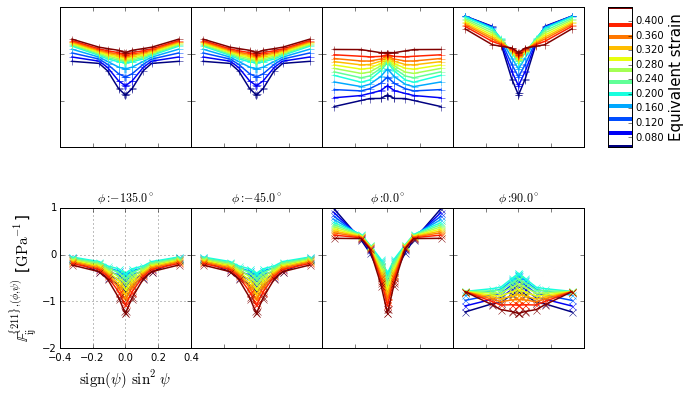

In [24]:
RS.SF.plot()

4
14
12
(12, 4, 14, 6)


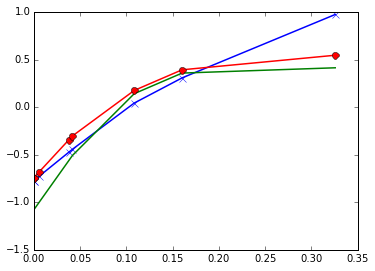

In [25]:
print len(RS.SF.phi)
print len(RS.SF.psi)
print RS.SF.nstp
print RS.SF.sf.shape
ft=RS.SF.psi>=0
x=RS.SF.psi[ft]
x=np.sin(x*np.pi/180.)**2
plot(x,RS.SF.sf[0,2,:,0][ft]*1e12,'-x')
#plot(x,RS.SF.sf[2,2,:,0][ft]*1e12,'-+')
plot(x,RS.SF.sf[-2,2,:,0][ft]*1e12,'-')
plot(x,RS.SF.sf[-5,2,:,0][ft]*1e12,'-o')

In [26]:
print fn_sff

/Users/yj/Documents/ExpDat/IFSteel/Marciniak-X-ray-IF/IF_PSRD.sff


In [27]:
help(sff_plot.f1122)

Help on function f1122 in module RS.sff_plot:

f1122(fn='debug.sff', ifig=1, iphi=0, i=1, j=1, ilab=True, title='EVPSC', ls='-', ieps=None)
    Arguments
    fn   = 'debug.sff'
    ifig = 1
    iphi = 1
    i    = 1 (starts from 1)
    j    = 1 (starts from 1)
    ilab = True
    ls   = '-'



23
#phivalues	5																											
nphi: 5
23
#phivalues	5																											
nphi: 5


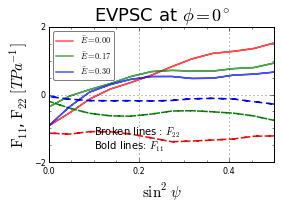

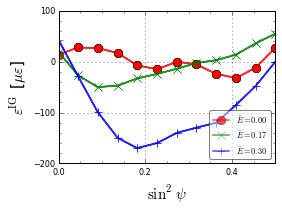

In [28]:
sff_plot.f1122(fn=fn_sff,i=1,j=1,iphi=0,ifig=0)
#sff_plot.f1122(fn=fn_sff,i=1,j=1,iphi=1,ifig=4)
#sff_plot.f1122(fn=fn_sff,i=1,j=1,iphi=2,ifig=8)
#sff_plot.f1122(fn=fn_sff,i=1,j=1,iphi=3,ifig=12)

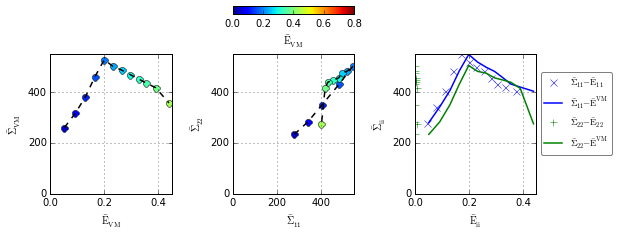

In [29]:
""" 
RS.EXP.flow.epsilon, RS.flow.sigma
"""
mn=0;mx=0.8
norm = mpl.colors.Normalize(vmin=mn,vmax=mx)
cmap, m = mpl_lib.norm_cmap(mn=mn,mx=mx)

fx=9
fy=fx*0.35
fig=plt.figure(figsize=(fx,fy))
gs=GS(20,3,wspace=0.5)
ax1=fig.add_subplot(gs[5:,0])
ax2=fig.add_subplot(gs[5:,1])
ax3=fig.add_subplot(gs[5:,2])

nstp = RS.EXP.flow.nstp

for istp in xrange(nstp):
    c=m.to_rgba(RS.EXP.flow.epsilon_vm[istp])
    ax2.plot(RS.flow.sigma[0,0][istp],RS.flow.sigma[1,1][istp],
             'o',mec='k',mfc=c)
    ax1.plot(RS.EXP.flow.epsilon_vm[istp],RS.flow.sigma_vm[istp],'o',c=c)

ax2.plot(RS.flow.sigma[0,0],RS.flow.sigma[1,1],'k--')
ax1.plot(RS.EXP.flow.epsilon_vm,RS.flow.sigma_vm,'k--')

l,=ax3.plot(RS.EXP.flow.epsilon[0,0],RS.flow.sigma[0,0],'x',label=r'$\mathrm{\bar{\Sigma}_{11} - \bar{E}_{11}}$')
ax3.plot(RS.EXP.flow.epsilon_vm,RS.flow.sigma[0,0],'-',color=l.get_color(),label=r'$\mathrm{\bar{\Sigma}_{11} - \bar{E}^{VM}}$')

l,=ax3.plot(RS.EXP.flow.epsilon[1,1],RS.flow.sigma[1,1],'+',label=r'$\mathrm{\bar{\Sigma}_{22} - \bar{E}_{22}}$')
ax3.plot(RS.EXP.flow.epsilon_vm,RS.flow.sigma[1,1],'-',color=l.get_color(),label=r'$\mathrm{\bar{\Sigma}_{22} - \bar{E}^{VM}}$')

for ax in fig.axes:
    ax.set_ylim(0.,);ax.set_xlim(0.,)
    ax.locator_params(nbins=4)
    ax.grid()

ax2.set_xlabel(r'$\mathrm{\bar{\Sigma}_{11}}$')
ax2.set_ylabel(r'$\mathrm{\bar{\Sigma}_{22}}$')
ax3.set_xlabel(r'$\mathrm{\bar{E}_{ii}}$')
ax3.set_ylabel(r'$\mathrm{\bar{\Sigma}_{ii}}$')
ax1.set_xlabel(r'$\mathrm{\bar{E}_{VM}}$')
ax1.set_ylabel(r'$\mathrm{\bar{\Sigma}_{VM}}$')
ax3.legend(loc='best',fontsize=9,numpoints=1,bbox_to_anchor=(1,0.9))


axcb=fig.add_subplot(gs[0,1])
cb=mpl.colorbar.ColorbarBase(axcb,cmap=cmap,orientation='horizontal',
                          norm=norm,filled=True,format='%3.1f')
# axcb.locator_params(nbins=4)
axcb.set_xlabel(r'$\mathrm{\bar{E}_{VM}}$')
cb.set_ticks(np.linspace(mn,mx,5))
#mpl_lib.add_cb(ax=axcb,cmap=cmap, filled=True,
#               format='%5.3f',norm=norm,
#               ylab=r'$\mathrm{\bar{E}_{VM}}$')

- Pickle the object 'RS' and save to a file

In [30]:
import cPickle as pickle
def save_object(obj, filename):
    with open(filename, 'wb') as output:
        pickle.dump(obj, output, pickle.HIGHEST_PROTOCOL)

fn = os.path.join(path,date,'RS.pck')
print fn
save_object(obj=RS, filename=fn)

fn = os.path.join('../../../pickles/RS_%s.pck'%date)
print os.path.join(os.getcwd(),fn)
save_object(obj=RS, filename=fn)


fn = os.path.join('../../../pickles/RS_DIC_%s.pck'%date)
print os.path.join(os.getcwd(),fn)
save_object(obj=myfc, filename=fn)

/Users/yj/Documents/ExpDat/IFSteel/Marciniak-X-ray-IF/PS/20141112/RS.pck
/Users/yj/repo/FLD_DIC_XRAY/tutorials/XRD_analysis/IF_steel/PSRD/../../../pickles/RS_20141112.pck
/Users/yj/repo/FLD_DIC_XRAY/tutorials/XRD_analysis/IF_steel/PSRD/../../../pickles/RS_DIC_20141112.pck
